**Troisième réseau** :  
     - Similaire au **Premier réseau**, mais cette fois, il vise à prédire trois classes au lieu de deux.
     - Objectif : prédire si un patient est sain ou atteint de pneumonie.  
     - Architecture basée sur des couches Conv2D et MaxPooling2D pour extraire les caractéristiques des images.  
     - Entraînement sur des images brutes redimensionnées à 16x16 pixels.  
     - Validation croisée à 10 plis  
     - Classes: ['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS']

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import collections
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

from keras.layers import Dropout


#Wilcoxon Test
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import wilcoxon

#Utilizado para guardar modelos y cargarlos
import joblib

import shap

import cv2

#Entrenamiento
batch_size = 64
nb_classes = 3
epochs = 50
crossValidationSplit = 10

In [9]:
def cnn_model(input_shape,nb_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Rescaling(1. / 255)(inputs)

    x = layers.Conv2D(32, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(nb_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [10]:
def charger_images_par_format_cv2(chemin):
    """
    Charge des images d'un chemin spécifique dont les noms suivent le format y_x.jpeg.
    Les images sont lues en niveaux de gris, leur taille originale est respectée, 
    et leur dimension du canal est explicitement ajoutée pour éviter toute perte d'information.
    
    Paramètres :
    chemin (str) : Chemin de base où chercher les images.
    
    Retourne :
    X (np.array) : Liste des images traitées.
    y (np.array) : Liste des labels extraits des noms des fichiers.
    input_shape (tuple) : Taille des images (hauteur, largeur, canaux).
    """
    X = []
    y = []
    dimensions = None

    # Chemin pour les images respectant le format spécifié
    chemin_images = rf'{chemin}\*_*.jpeg'

    # Parcourir toutes les images correspondant au modèle
    for fichier in glob.glob(chemin_images):
        # Lire l'image en niveaux de gris
        image = cv2.imread(fichier, cv2.IMREAD_GRAYSCALE)
        if image is not None:  # Vérifier si l'image a été correctement chargée
            # Ajouter une dimension pour le canal
            image = np.expand_dims(image, axis=-1)
            X.append(image)
            
            # Vérifier et conserver la taille de la première image
            if dimensions is None:
                hauteur, largeur = image.shape[:2]
                dimensions = (hauteur, largeur, 1)  # Ajouter explicitement le canal (gris)
            
            # Extraire le label y depuis le nom de fichier
            nom = fichier.split('\\')[-1].replace('.jpeg', '')  # Récupérer le nom sans extension
            label = int(nom.split('_')[0])  # Extraire 'y' avant le '_'
            
            y.append(label)
        else:
            print(f"Impossible de lire l'image : {fichier}")

    # Convertir X et y en tableaux numpy
    return np.array(X), np.array(y), dimensions

In [11]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(n, 3))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,0])
        plt.gray()
        ax.set_title('{}-{}'.format(y[index[i]],index[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [12]:
def enregistrer_tableau_dans_txt(tableau, nom_fichier):
    """
    Enregistre les éléments d'un tableau dans un fichier .txt.

    Args:
        tableau (list): Liste des éléments à enregistrer.
        nom_fichier (str): Nom du fichier (doit inclure l'extension .txt).
    
    Returns:
        None
    """
    try:
        # Ouvrir le fichier en mode écriture
        with open(nom_fichier, 'w', encoding='utf-8') as fichier:
            # Écrire chaque élément du tableau sur une nouvelle ligne
            for element in tableau:
                fichier.write(str(element) + '\n')
        print(f"Tableau enregistré avec succès dans '{nom_fichier}'")
    except Exception as e:
        print(f"Erreur lors de l'enregistrement du fichier : {e}")

(5832, 16, 16, 1) échantillons d'entraînement
(16, 16, 1) input_shape
50 epochs


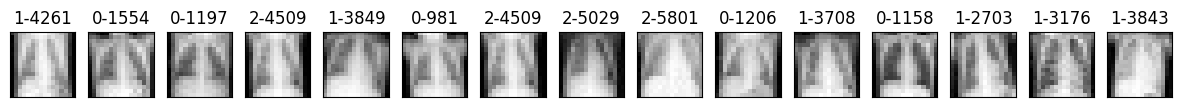

x_train (5248, 16, 16, 1) x_test (584, 16, 16, 1)
y_train (5248,) y_test (584,)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 2s - 28ms/step - accuracy: 0.4728 - loss: 1.0557 - val_accuracy: 0.4743 - val_loss: 0.9996
Epoch 2/50
82/82 - 1s - 7ms/step - accuracy: 0.6174 - loss: 0.8583 - val_accuracy: 0.6764 - val_loss: 0.7377
Epoch 3/50
82/82 - 1s - 6ms/step - accuracy: 0.6881 - loss: 0.7091 - val_accuracy: 0.7260 - val_loss: 0.6120
Epoch 4/50
82/82 - 1s - 7ms/step - accuracy: 0.7069 - loss: 0.6465 - val_accuracy: 0.7363 - val_loss: 0.5800
Epoch 5/50
82/82 - 0s - 6ms/step - accuracy: 0.7262 - loss: 0.6115 - val_accuracy: 0.7414 - val_loss: 0.5732
Epoch 6/50
82/82 - 1s - 6ms/step - accuracy: 0.7340 - loss: 0.6028 - val_accuracy: 0.7346 - val_loss: 0.6050
Epoch 7/50
82/82 - 1s - 6ms/step - accuracy: 0.7586 - loss: 0.5702 - val_accuracy: 0.7620 - val_loss: 0.5691
Epoch 8/50
82/82 - 1s - 6ms/step - accuracy: 0.7652 - loss: 0.5516 - val_accuracy: 0.7705 - val_loss: 0.5481
Epoch 9/50
82/82 - 1s - 6ms/step - accuracy: 0.7757 - loss: 0.5373 - val_accuracy: 0.7791 - val_loss: 0.5334
Epoch 10/50
8

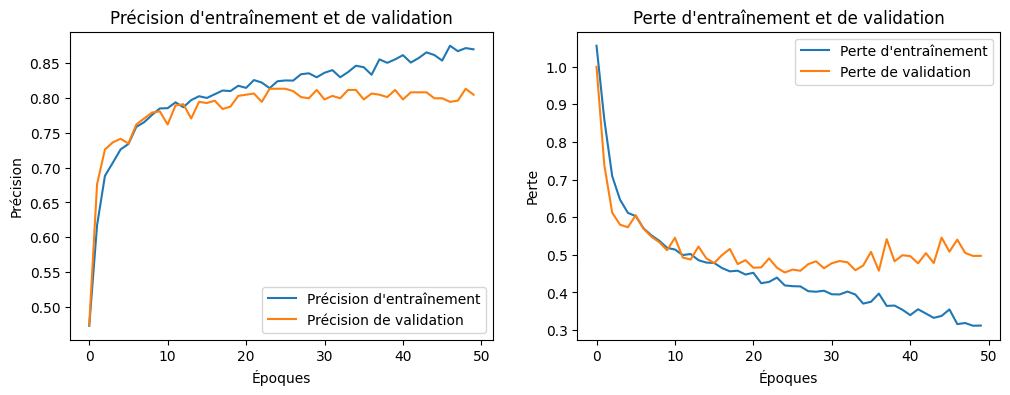

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8812 - loss: 0.3139 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 1:
perte: 0.50 précision: 0.80
AUC 0.9207
Prédictions
Counter({np.int64(1): 290, np.int64(0): 167, np.int64(2): 127}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.90      0.95      0.92       158
Pneumonia_bacteriana       0.82      0.86      0.84       277
     Pneumonia_viral       0.65      0.56      0.60       149

            accuracy                           0.80       584
           macro avg       0.79      0.79      0.79       584
        weighted avg       0.80      0.80      0.80       584

Matrice de confusion


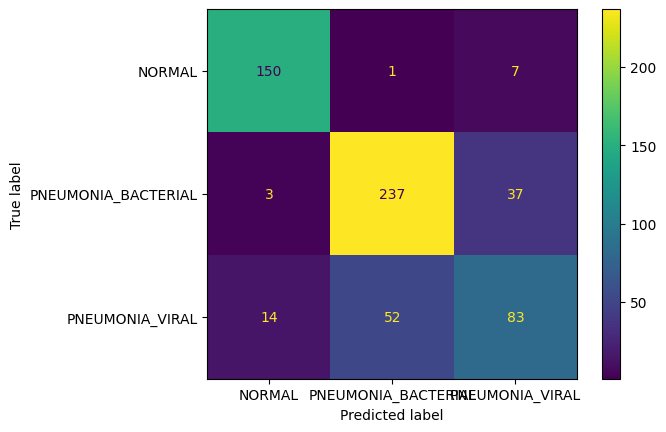

x_train (5248, 16, 16, 1) x_test (584, 16, 16, 1)
y_train (5248,) y_test (584,)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 2s - 29ms/step - accuracy: 0.4724 - loss: 1.0651 - val_accuracy: 0.4743 - val_loss: 1.0461
Epoch 2/50
82/82 - 0s - 6ms/step - accuracy: 0.5958 - loss: 0.8780 - val_accuracy: 0.6661 - val_loss: 0.7562
Epoch 3/50
82/82 - 1s - 6ms/step - accuracy: 0.6959 - loss: 0.6814 - val_accuracy: 0.6832 - val_loss: 0.6747
Epoch 4/50
82/82 - 0s - 6ms/step - accuracy: 0.7130 - loss: 0.6334 - val_accuracy: 0.7277 - val_loss: 0.6314
Epoch 5/50
82/82 - 0s - 6ms/step - accuracy: 0.7288 - loss: 0.6113 - val_accuracy: 0.7312 - val_loss: 0.6125
Epoch 6/50
82/82 - 0s - 5ms/step - accuracy: 0.7346 - loss: 0.5873 - val_accuracy: 0.7449 - val_loss: 0.5881
Epoch 7/50
82/82 - 1s - 6ms/step - accuracy: 0.7473 - loss: 0.5672 - val_accuracy: 0.7277 - val_loss: 0.6427
Epoch 8/50
82/82 - 1s - 6ms/step - accuracy: 0.7580 - loss: 0.5423 - val_accuracy: 0.7432 - val_loss: 0.5877
Epoch 9/50
82/82 - 1s - 7ms/step - accuracy: 0.7742 - loss: 0.5260 - val_accuracy: 0.7586 - val_loss: 0.5645
Epoch 10/50
8

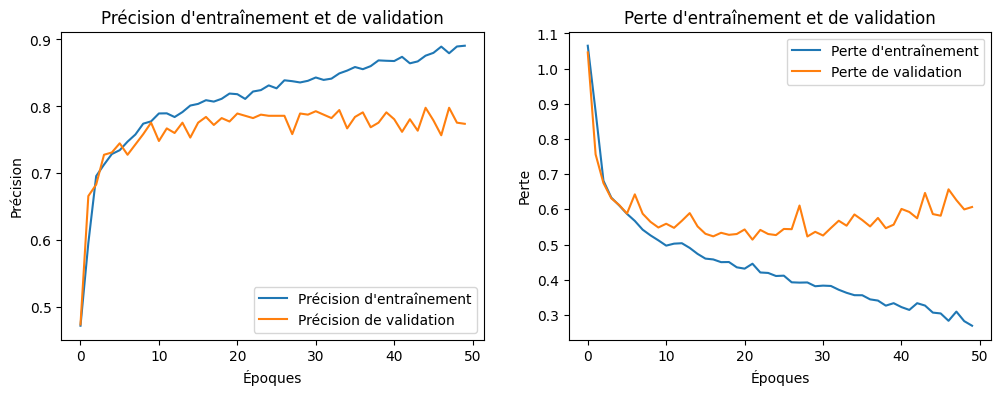

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8348 - loss: 0.4719 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 2:
perte: 0.61 précision: 0.77
AUC 0.9069
Prédictions
Counter({np.int64(1): 250, np.int64(2): 172, np.int64(0): 162}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.90      0.92      0.91       158
Pneumonia_bacteriana       0.84      0.76      0.80       277
     Pneumonia_viral       0.56      0.65      0.60       149

            accuracy                           0.77       584
           macro avg       0.77      0.78      0.77       584
        weighted avg       0.78      0.77      0.78       584

Matrice de confusion


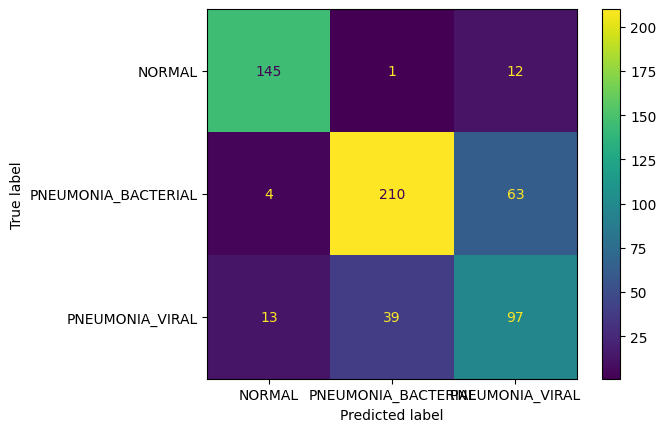

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.4999 - loss: 1.0347 - val_accuracy: 0.5540 - val_loss: 0.9450
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.6325 - loss: 0.8193 - val_accuracy: 0.5746 - val_loss: 0.9548
Epoch 3/50
83/83 - 0s - 6ms/step - accuracy: 0.6599 - loss: 0.7754 - val_accuracy: 0.6964 - val_loss: 0.6497
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.7039 - loss: 0.6568 - val_accuracy: 0.7307 - val_loss: 0.6085
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.7161 - loss: 0.6333 - val_accuracy: 0.7273 - val_loss: 0.5887
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.7361 - loss: 0.5973 - val_accuracy: 0.7187 - val_loss: 0.6206
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7417 - loss: 0.5806 - val_accuracy: 0.7204 - val_loss: 0.6153
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.7500 - loss: 0.5634 - val_accuracy: 0.7170 - val_loss: 0.6199
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.7685 - loss: 0.5407 - val_accuracy: 0.7564 - val_loss: 0.5506
Epoch 10/50
8

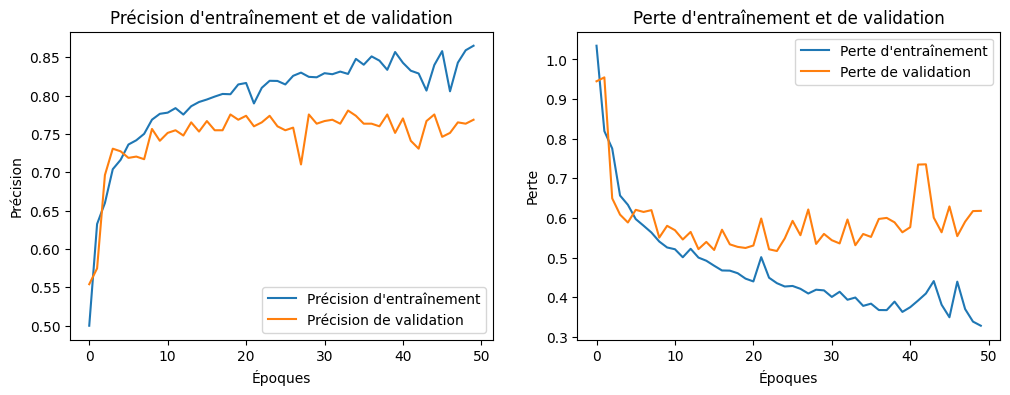

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8356 - loss: 0.5477 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 3:
perte: 0.62 précision: 0.77
AUC 0.8999
Prédictions
Counter({np.int64(1): 322, np.int64(0): 154, np.int64(2): 107}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.91      0.89      0.90       158
Pneumonia_bacteriana       0.75      0.88      0.81       277
     Pneumonia_viral       0.61      0.44      0.51       148

            accuracy                           0.77       583
           macro avg       0.76      0.73      0.74       583
        weighted avg       0.76      0.77      0.76       583

Matrice de confusion


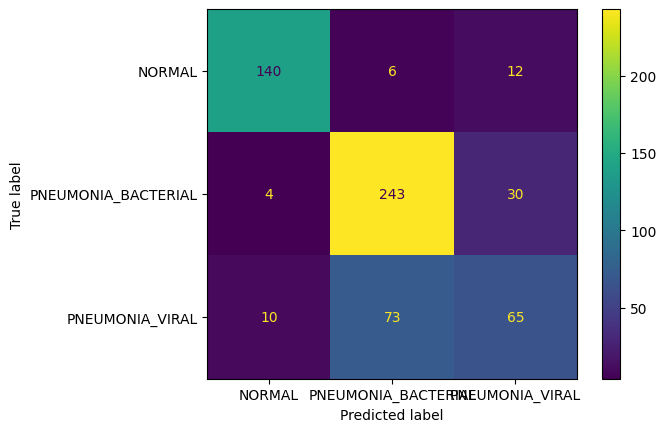

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 29ms/step - accuracy: 0.4711 - loss: 1.0597 - val_accuracy: 0.4751 - val_loss: 1.0093
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.6114 - loss: 0.8572 - val_accuracy: 0.6569 - val_loss: 0.7451
Epoch 3/50
83/83 - 1s - 6ms/step - accuracy: 0.6807 - loss: 0.7285 - val_accuracy: 0.6827 - val_loss: 0.6581
Epoch 4/50
83/83 - 1s - 7ms/step - accuracy: 0.7058 - loss: 0.6618 - val_accuracy: 0.7341 - val_loss: 0.5698
Epoch 5/50
83/83 - 1s - 7ms/step - accuracy: 0.7169 - loss: 0.6280 - val_accuracy: 0.7444 - val_loss: 0.5448
Epoch 6/50
83/83 - 1s - 7ms/step - accuracy: 0.7278 - loss: 0.6081 - val_accuracy: 0.7427 - val_loss: 0.5642
Epoch 7/50
83/83 - 1s - 7ms/step - accuracy: 0.7268 - loss: 0.6077 - val_accuracy: 0.7890 - val_loss: 0.5078
Epoch 8/50
83/83 - 1s - 7ms/step - accuracy: 0.7516 - loss: 0.5675 - val_accuracy: 0.7907 - val_loss: 0.4899
Epoch 9/50
83/83 - 1s - 7ms/step - accuracy: 0.7649 - loss: 0.5416 - val_accuracy: 0.7770 - val_loss: 0.4907
Epoch 10/50
8

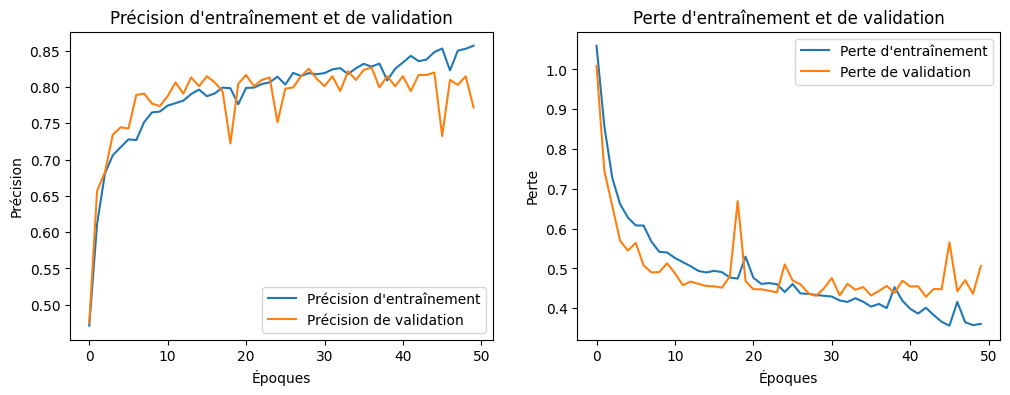

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8388 - loss: 0.3556 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 4:
perte: 0.51 précision: 0.77
AUC 0.9199
Prédictions
Counter({np.int64(1): 229, np.int64(2): 179, np.int64(0): 175}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.87      0.96      0.91       158
Pneumonia_bacteriana       0.85      0.70      0.77       277
     Pneumonia_viral       0.58      0.70      0.63       148

            accuracy                           0.77       583
           macro avg       0.77      0.79      0.77       583
        weighted avg       0.79      0.77      0.77       583

Matrice de confusion


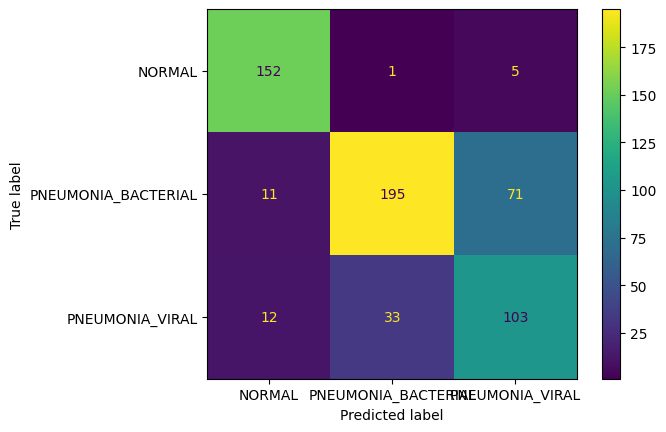

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 27ms/step - accuracy: 0.4725 - loss: 1.0642 - val_accuracy: 0.4751 - val_loss: 1.0425
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.5630 - loss: 0.9211 - val_accuracy: 0.6621 - val_loss: 0.7482
Epoch 3/50
83/83 - 1s - 6ms/step - accuracy: 0.6843 - loss: 0.7045 - val_accuracy: 0.6690 - val_loss: 0.7456
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.7018 - loss: 0.6790 - val_accuracy: 0.7221 - val_loss: 0.6098
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.7177 - loss: 0.6374 - val_accuracy: 0.6930 - val_loss: 0.7109
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.7259 - loss: 0.6232 - val_accuracy: 0.5660 - val_loss: 1.0962
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.6748 - loss: 0.7193 - val_accuracy: 0.7358 - val_loss: 0.5878
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.7400 - loss: 0.5957 - val_accuracy: 0.7256 - val_loss: 0.6050
Epoch 9/50
83/83 - 1s - 6ms/step - accuracy: 0.7485 - loss: 0.5735 - val_accuracy: 0.7513 - val_loss: 0.5433
Epoch 10/50
8

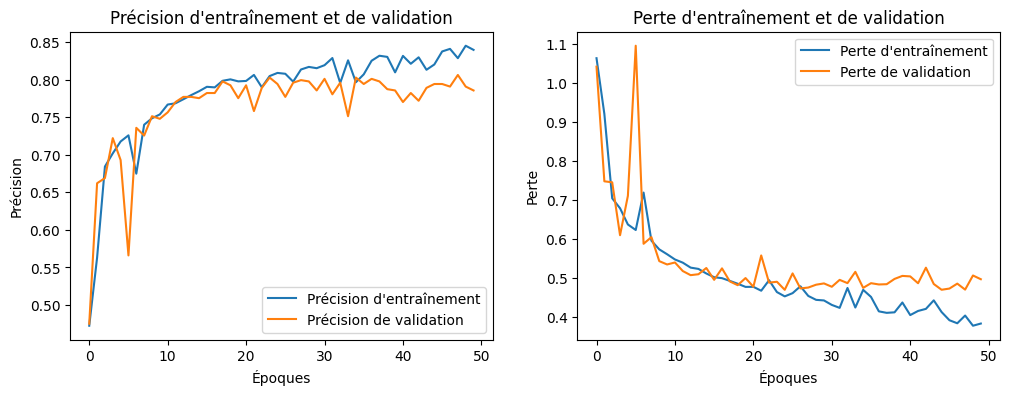

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8446 - loss: 0.3808 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 5:
perte: 0.50 précision: 0.79
AUC 0.9174
Prédictions
Counter({np.int64(1): 258, np.int64(0): 163, np.int64(2): 162}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.90      0.93      0.92       158
Pneumonia_bacteriana       0.83      0.77      0.80       277
     Pneumonia_viral       0.60      0.66      0.63       148

            accuracy                           0.79       583
           macro avg       0.78      0.79      0.78       583
        weighted avg       0.79      0.79      0.79       583

Matrice de confusion


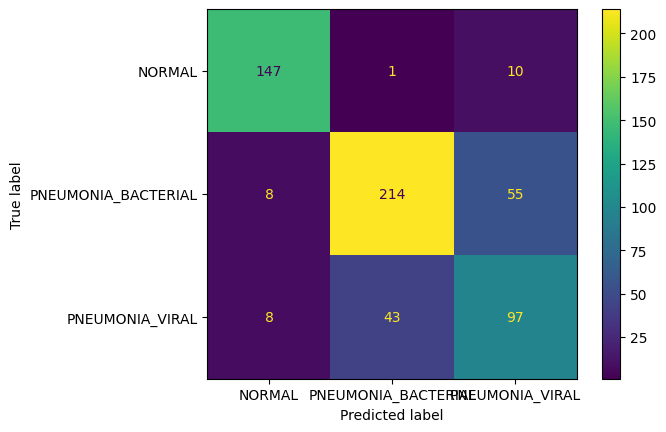

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.4841 - loss: 1.0418 - val_accuracy: 0.4717 - val_loss: 1.0423
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.6447 - loss: 0.7942 - val_accuracy: 0.6964 - val_loss: 0.6895
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.7007 - loss: 0.6650 - val_accuracy: 0.6123 - val_loss: 0.8730
Epoch 4/50
83/83 - 1s - 7ms/step - accuracy: 0.6874 - loss: 0.6905 - val_accuracy: 0.6724 - val_loss: 0.7195
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.7051 - loss: 0.6345 - val_accuracy: 0.7376 - val_loss: 0.6140
Epoch 6/50
83/83 - 1s - 6ms/step - accuracy: 0.7251 - loss: 0.6143 - val_accuracy: 0.6844 - val_loss: 0.6968
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7062 - loss: 0.6501 - val_accuracy: 0.7358 - val_loss: 0.6054
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.7466 - loss: 0.5794 - val_accuracy: 0.7496 - val_loss: 0.5854
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.7523 - loss: 0.5695 - val_accuracy: 0.7650 - val_loss: 0.5688
Epoch 10/50
8

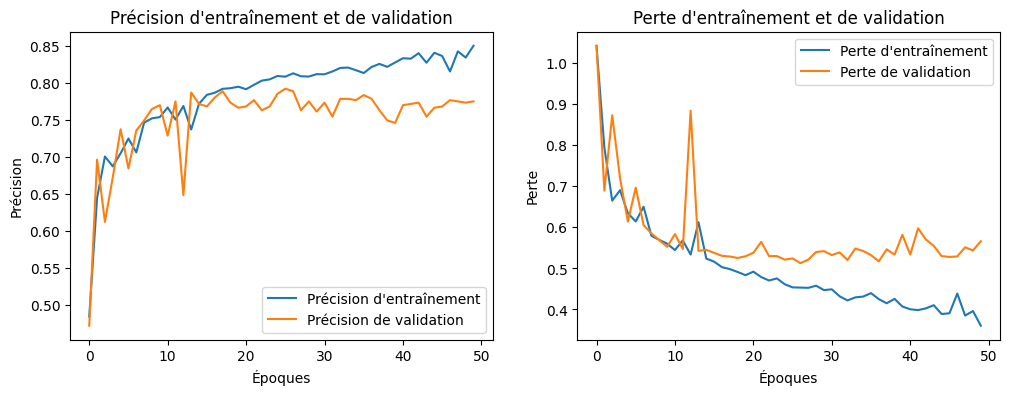

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8664 - loss: 0.3544 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 6:
perte: 0.57 précision: 0.78
AUC 0.8993
Prédictions
Counter({np.int64(1): 292, np.int64(0): 176, np.int64(2): 115}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.86      0.96      0.91       157
Pneumonia_bacteriana       0.79      0.83      0.81       278
     Pneumonia_viral       0.62      0.48      0.54       148

            accuracy                           0.78       583
           macro avg       0.75      0.76      0.75       583
        weighted avg       0.76      0.78      0.77       583

Matrice de confusion


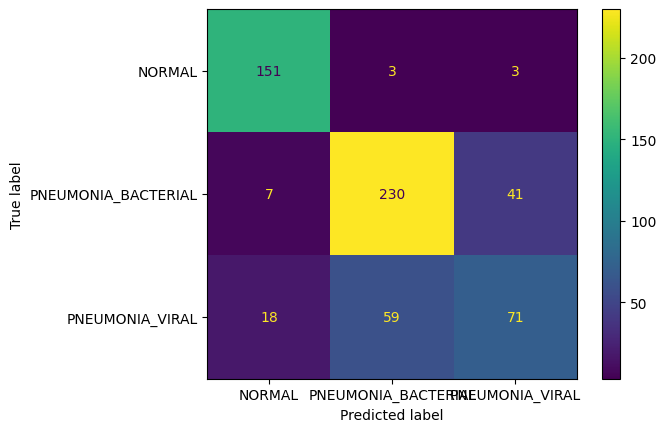

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.4736 - loss: 1.0641 - val_accuracy: 0.4768 - val_loss: 1.0493
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.5904 - loss: 0.8801 - val_accuracy: 0.5695 - val_loss: 1.0011
Epoch 3/50
83/83 - 1s - 6ms/step - accuracy: 0.6832 - loss: 0.7138 - val_accuracy: 0.7067 - val_loss: 0.6575
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.7062 - loss: 0.6524 - val_accuracy: 0.6552 - val_loss: 0.7332
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.7144 - loss: 0.6450 - val_accuracy: 0.6930 - val_loss: 0.6772
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.7306 - loss: 0.6107 - val_accuracy: 0.7238 - val_loss: 0.6145
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7407 - loss: 0.5870 - val_accuracy: 0.7496 - val_loss: 0.5881
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.7502 - loss: 0.5669 - val_accuracy: 0.7341 - val_loss: 0.6057
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.7596 - loss: 0.5490 - val_accuracy: 0.7581 - val_loss: 0.5689
Epoch 10/50
8

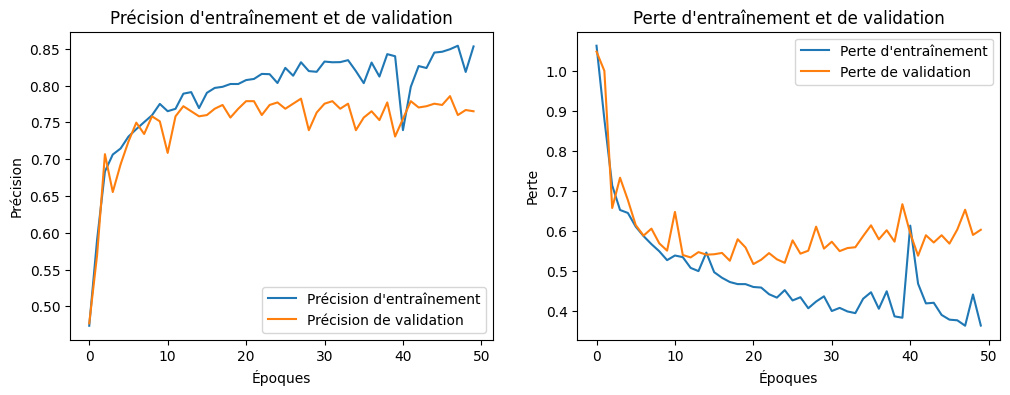

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8331 - loss: 0.4972 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 7:
perte: 0.60 précision: 0.77
AUC 0.8995
Prédictions
Counter({np.int64(1): 305, np.int64(0): 149, np.int64(2): 129}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.89      0.85      0.87       157
Pneumonia_bacteriana       0.78      0.86      0.82       278
     Pneumonia_viral       0.58      0.51      0.54       148

            accuracy                           0.77       583
           macro avg       0.75      0.74      0.74       583
        weighted avg       0.76      0.77      0.76       583

Matrice de confusion


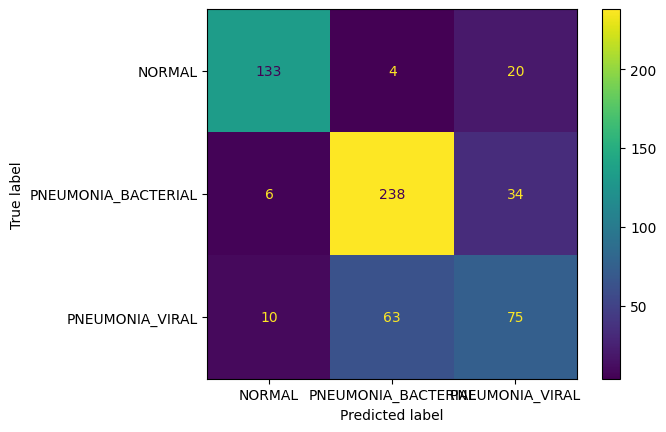

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 31ms/step - accuracy: 0.4925 - loss: 1.0343 - val_accuracy: 0.6569 - val_loss: 0.8495
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.6559 - loss: 0.7727 - val_accuracy: 0.6913 - val_loss: 0.6763
Epoch 3/50
83/83 - 0s - 6ms/step - accuracy: 0.6942 - loss: 0.6863 - val_accuracy: 0.6655 - val_loss: 0.7395
Epoch 4/50
83/83 - 1s - 6ms/step - accuracy: 0.7098 - loss: 0.6499 - val_accuracy: 0.7084 - val_loss: 0.6729
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.7232 - loss: 0.6151 - val_accuracy: 0.7496 - val_loss: 0.5735
Epoch 6/50
83/83 - 1s - 6ms/step - accuracy: 0.7283 - loss: 0.6064 - val_accuracy: 0.7376 - val_loss: 0.5728
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7420 - loss: 0.5688 - val_accuracy: 0.7564 - val_loss: 0.5673
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.7552 - loss: 0.5544 - val_accuracy: 0.7667 - val_loss: 0.5265
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.7714 - loss: 0.5368 - val_accuracy: 0.7530 - val_loss: 0.6033
Epoch 10/50
8

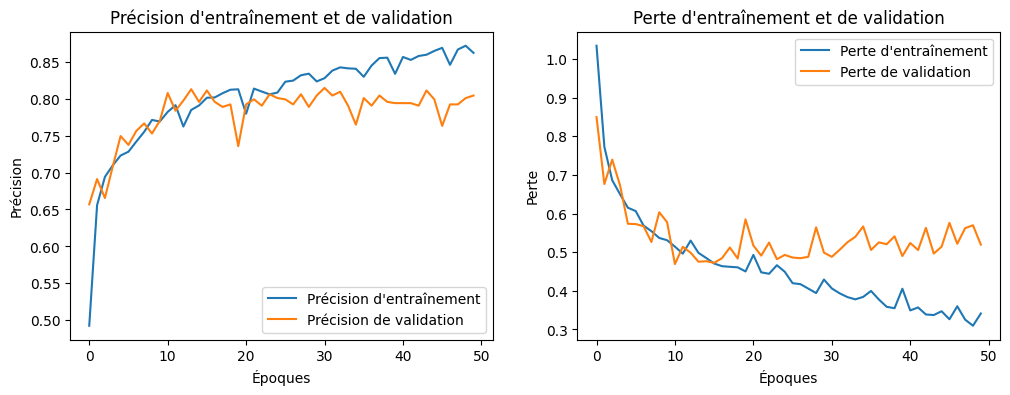

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8540 - loss: 0.4205
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 8:
perte: 0.52 précision: 0.80
AUC 0.9207
Prédictions
Counter({np.int64(1): 272, np.int64(0): 157, np.int64(2): 154}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.92      0.92      0.92       157
Pneumonia_bacteriana       0.83      0.82      0.82       277
     Pneumonia_viral       0.64      0.66      0.65       149

            accuracy                           0.80       583
           macro avg       0.80      0.80      0.80       583
        weighted avg       0.81      0.80      0.81       583

Matrice de confusion


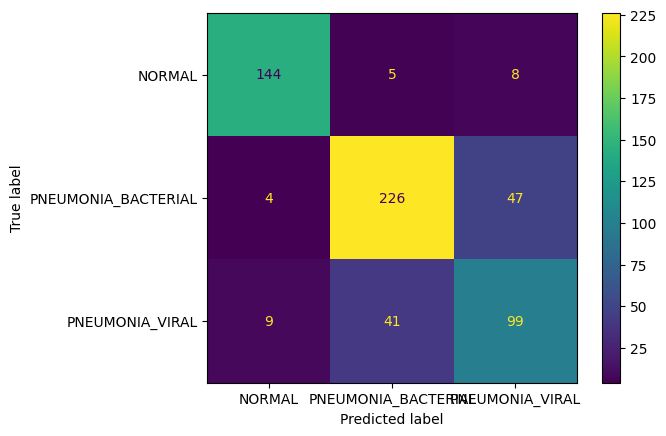

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.4812 - loss: 1.0417 - val_accuracy: 0.5129 - val_loss: 0.9554
Epoch 2/50
83/83 - 1s - 8ms/step - accuracy: 0.6525 - loss: 0.7953 - val_accuracy: 0.7033 - val_loss: 0.6452
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.6889 - loss: 0.6915 - val_accuracy: 0.6913 - val_loss: 0.6916
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.7089 - loss: 0.6475 - val_accuracy: 0.7307 - val_loss: 0.6415
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.7106 - loss: 0.6380 - val_accuracy: 0.7084 - val_loss: 0.6669
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.7230 - loss: 0.6140 - val_accuracy: 0.6655 - val_loss: 0.7071
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7034 - loss: 0.6563 - val_accuracy: 0.7221 - val_loss: 0.5890
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.7319 - loss: 0.5925 - val_accuracy: 0.7033 - val_loss: 0.5964
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.7367 - loss: 0.5848 - val_accuracy: 0.7307 - val_loss: 0.5863
Epoch 10/50
8

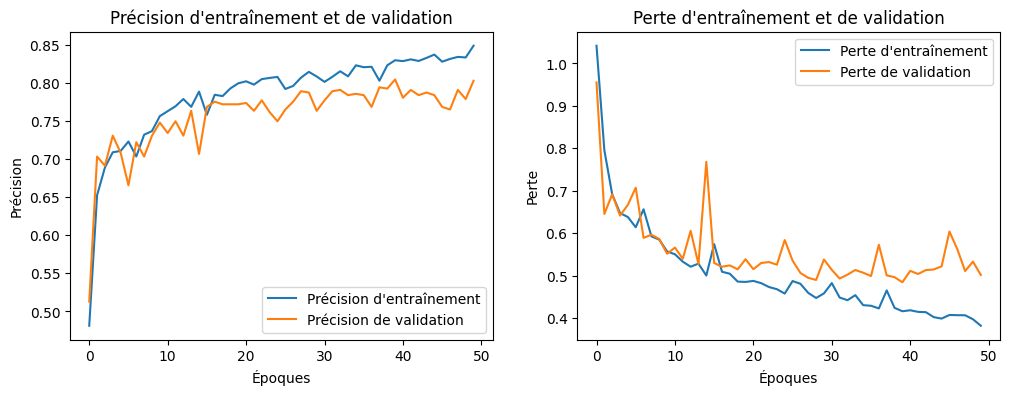

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8672 - loss: 0.3832 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 9:
perte: 0.50 précision: 0.80
AUC 0.9166
Prédictions
Counter({np.int64(1): 290, np.int64(0): 160, np.int64(2): 133}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.91      0.93      0.92       157
Pneumonia_bacteriana       0.81      0.84      0.83       277
     Pneumonia_viral       0.66      0.59      0.62       149

            accuracy                           0.80       583
           macro avg       0.79      0.79      0.79       583
        weighted avg       0.80      0.80      0.80       583

Matrice de confusion


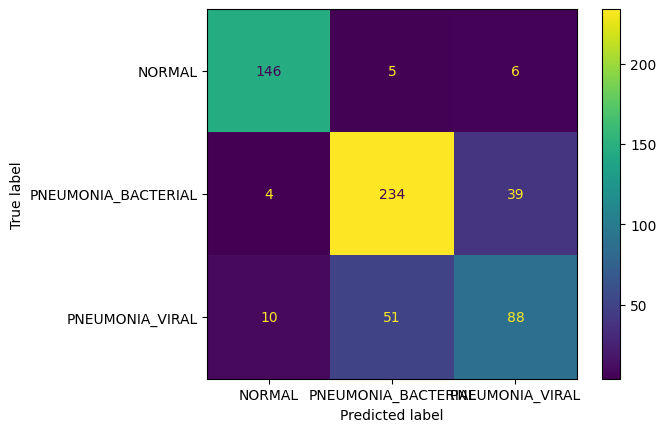

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 27ms/step - accuracy: 0.4875 - loss: 1.0424 - val_accuracy: 0.4425 - val_loss: 1.0558
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.6110 - loss: 0.8621 - val_accuracy: 0.6672 - val_loss: 0.7319
Epoch 3/50
83/83 - 0s - 6ms/step - accuracy: 0.6801 - loss: 0.7244 - val_accuracy: 0.6947 - val_loss: 0.6878
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.6990 - loss: 0.6738 - val_accuracy: 0.6878 - val_loss: 0.6976
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.7057 - loss: 0.6520 - val_accuracy: 0.7136 - val_loss: 0.6288
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.7207 - loss: 0.6279 - val_accuracy: 0.6792 - val_loss: 0.7073
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7203 - loss: 0.6239 - val_accuracy: 0.7153 - val_loss: 0.6080
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.7348 - loss: 0.6078 - val_accuracy: 0.7358 - val_loss: 0.5761
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.7459 - loss: 0.5806 - val_accuracy: 0.7479 - val_loss: 0.5567
Epoch 10/50
8

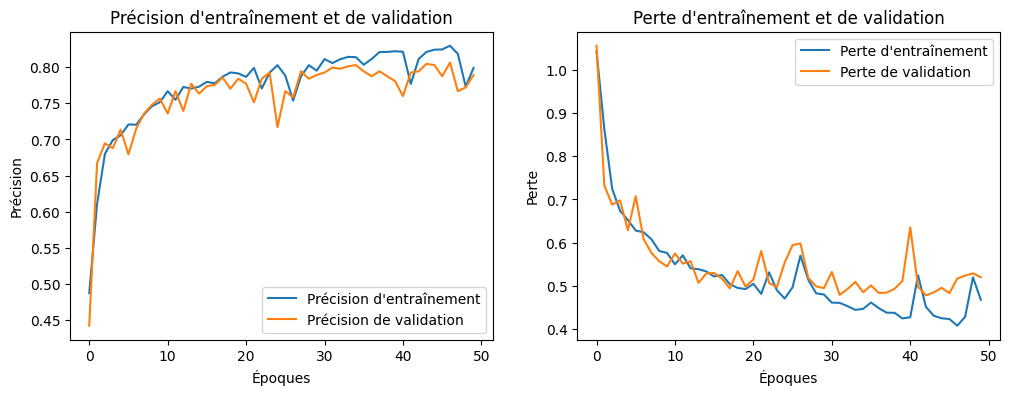

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8743 - loss: 0.3536 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 10:
perte: 0.52 précision: 0.79
AUC 0.9002
Prédictions
Counter({np.int64(1): 351, np.int64(0): 158, np.int64(2): 74}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.91      0.91      0.91       157
Pneumonia_bacteriana       0.74      0.94      0.83       277
     Pneumonia_viral       0.76      0.38      0.50       149

            accuracy                           0.79       583
           macro avg       0.80      0.74      0.75       583
        weighted avg       0.79      0.79      0.77       583

Matrice de confusion


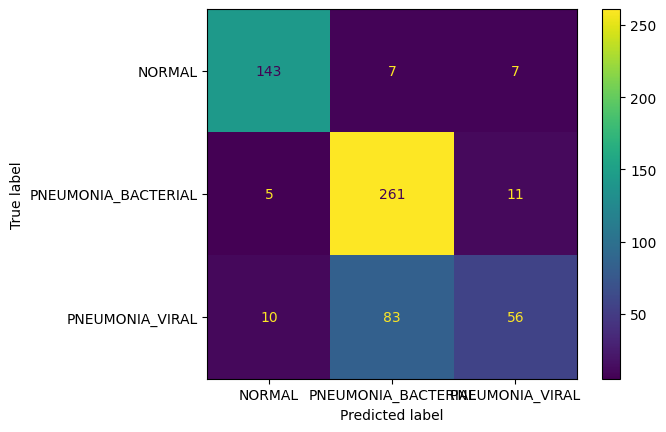

Le meilleur modèle a été sauvegardé avec un ROC de: 0.9206920363482295
Fin de l'entraînement
Résultats ROC:
0.9206920363482295

0.9069277742889369

0.8999144221921237

0.9198769201527454

0.9174496970527345

0.8993030477973258

0.8995452469121764

0.9206522656607495

0.9165504250573774

0.9001926651465785

Tableau enregistré avec succès dans 'resultatsROC_2_1.txt'


In [13]:
def main(path): 
    resultatsROC = []
    
    X, y, input_shape = charger_images_par_format_cv2(path)

    print(X.shape, 'échantillons d\'entraînement')  # Traducción: train samples
    print(input_shape,'input_shape')
    print(epochs,'epochs')

    plot_symbols(X, y)
    collections.Counter(y)

    # CV-10
    kf = StratifiedKFold(n_splits=crossValidationSplit, shuffle=True, random_state=123)

    splitEntrenamiento = 1
    meilleur_roc = -1  # Para almacenar el mejor valor de ROC
    meilleur_modele = None  # Para guardar el mejor modelo

    for train_index, test_index in kf.split(X, y):
       # Division des données en ensemble d'entraînement et de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Informations sur les dimensions des données
        print(f'x_train {X_train.shape} x_test {X_test.shape}')
        print(f'y_train {y_train.shape} y_test {y_test.shape}')

        # Création du modèle
        model = cnn_model(input_shape, nb_classes)
        print(model.summary())

        # Compilation du modèle
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Entraînement du modèle directement avec les données
        history = model.fit(X_train, y_train, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_data=(X_test, y_test), 
            verbose=2)
        # Obtener las métricas del historial
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Graficar la precisión
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Précision d\'entraînement')  # Traducción: Training Accuracy
        plt.plot(val_acc, label='Précision de validation')  # Traducción: Validation Accuracy
        plt.legend()
        plt.title('Précision d\'entraînement et de validation')  # Traducción: Training and Validation Accuracy
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Précision')  # Traducción: Accuracy

        # Graficar la pérdida
        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Perte d\'entraînement')  # Traducción: Training Loss
        plt.plot(val_loss, label='Perte de validation')  # Traducción: Validation Loss
        plt.legend()
        plt.title('Perte d\'entraînement et de validation')  # Traducción: Training and Validation Loss
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Perte')  # Traducción: Loss

        plt.show()

        # Visualizar datos del split
        loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
        y_pred = model.predict(X_test)

        # Guardar datos ROC
        roc = roc_auc_score(y_test, y_pred, multi_class='ovr')
        resultatsROC.append(roc)

        # Guardar el mejor modelo
        if roc > meilleur_roc:
            meilleur_roc = roc
            meilleur_modele = model

        # Graficas sobre Test
        print(f"Partition numéro {splitEntrenamiento}:")  # Traducción: Split número
        print(f'perte: {loss:.2f} précision: {acc:.2f}')  # Traducción: loss, acc
        print(f'AUC {roc:.4f}')

        print('Prédictions')  # Traducción: Predictions
        y_pred_int = y_pred.argmax(axis=1)
        print(collections.Counter(y_pred_int), '\n')

        print('Métriques')  # Traducción: Metrics
        print(metrics.classification_report(y_test, y_pred_int, target_names=['Normal', 'Pneumonia_bacteriana', 'Pneumonia_viral']))

        print('Matrice de confusion')  # Traducción: Confusion matrix
        metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred_int),
                                       display_labels=['NORMAL', 'PNEUMONIA_BACTERIAL','PNEUMONIA_VIRAL']).plot()
        plt.show()

        splitEntrenamiento += 1

    # Guardar el mejor modelo
    if meilleur_modele:
        meilleur_modele.save(r"..\models\meilleur_modele_roc_2_1.h5")
        print("Le meilleur modèle a été sauvegardé avec un ROC de:", meilleur_roc)  # Traducción: El mejor modelo fue guardado con un ROC de.

    print("Fin de l\'entraînement")  # Traducción: Fin de entrenamiento
    
    print("Résultats ROC:")  # Traducción: Resultados ROC
    for r in resultatsROC:
        print(f"{r}\n")
        
    enregistrer_tableau_dans_txt(resultatsROC, "resultatsROC_2_1.txt")

if __name__ == '__main__':
    path_save_16x16=r"..\data\processed\images_16x16"
    main(path_save_16x16)
